# **Import Dataset and Labels**

In [1]:
# This code is to set GPU to expand only when needed, otherwise it occupies the whole space and training stops in between
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import pandas as pd
x = pd.read_csv('/home/cadcam/Aman/ML Based Strategy Selection/ML based selection/Datasets/dataset_a_n.csv', delimiter=',')
y = pd.read_csv('/home/cadcam/Aman/ML Based Strategy Selection/ML based selection/Datasets/labels_a_n.csv', delimiter=',')

In [3]:
#x.drop(x.columns[[0]], axis=1, inplace=True)
x=x.values # convert to numpy array to perform preprocessing
y=y.values-1 # labels converted from 1,2,3 to 0,1,2 so that num_classes can be made = 3
x.shape

(10000, 8853)

# **Pre-Processing**

In [4]:
# Train test split
import numpy as np
from sklearn.model_selection import train_test_split

x=np.transpose(x)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=30, shuffle=True)

In [5]:
# Turn scalar targets into binary categories: Binary hot encoding
import tensorflow.keras as keras
num_classes = 3
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize data with max value of the model
x_train = x_train / np.amax(x)
x_valid = x_valid / np.amax(x)

x_train = x_train.reshape(-1,100,100,1)
x_valid = x_valid.reshape(-1,100,100,1)

# **Model Creation**

## ANN Model

In [44]:
# Import model libraries and create model for ANN
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=1e-2, momentum=0.9, decay=0.01)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
model=Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(10000,)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=3, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 512)               5120512   
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_22 (Dense)             (None, 3)                 387       
Total params: 5,547,779
Trainable params: 5,547,779
Non-trainable params: 0
_________________________________________________________________


## **CNN BASED MODEL**

In [7]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)
opt = SGD(learning_rate=1e-2, momentum=0.8, nesterov=False, decay=0.001)
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10)
#opt='rmsprop'
#opt='adam'
model = Sequential()
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="sigmoid", 
                 input_shape=(100, 100, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))
#model.add(Dense(3,kernel_regularizer=l2(0.01),activation = "softmax")) #for CNN with SVM add dense layer with regularizer

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 50)      500       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 50)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 25)        11275     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 25)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 25)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15625)             0

## **Model Fitting (Training)**

In [9]:
model.compile(loss="categorical_crossentropy",optimizer=opt, metrics=["accuracy"])
history=model.fit(x_train, y_train, epochs=60, verbose=1, callbacks=[rlrop], validation_data=(x_valid, y_valid), batch_size=50)

# For CNN with SVM use squared hinge function instead of Cross entropy
#model.compile(optimizer=opt,loss='squared_hinge', metrics = ["accuracy"])
#history=model.fit(x_train, y_train, epochs=60, verbose=1, validation_data=(x_valid, y_valid))

Train on 7082 samples, validate on 1771 samples
Epoch 1/60
7082/7082 [==============================] - 11s 2ms/sample - loss: 0.3173 - accuracy: 0.9036 - val_loss: 1.4922 - val_accuracy: 0.3264
Epoch 2/60
7082/7082 [==============================] - 2s 343us/sample - loss: 0.1706 - accuracy: 0.9396 - val_loss: 1.2992 - val_accuracy: 0.4658
Epoch 3/60
7082/7082 [==============================] - 2s 340us/sample - loss: 0.1426 - accuracy: 0.9490 - val_loss: 0.9937 - val_accuracy: 0.5573
Epoch 4/60
7082/7082 [==============================] - 2s 352us/sample - loss: 0.1303 - accuracy: 0.9520 - val_loss: 0.5144 - val_accuracy: 0.7804
Epoch 5/60
7082/7082 [==============================] - 2s 344us/sample - loss: 0.1179 - accuracy: 0.9555 - val_loss: 0.1533 - val_accuracy: 0.9401
Epoch 6/60
7082/7082 [==============================] - 2s 347us/sample - loss: 0.1131 - accuracy: 0.9569 - val_loss: 0.1205 - val_accuracy: 0.9588
Epoch 7/60
7082/7082 [==============================] - 3s 357us/

Epoch 56/60
7082/7082 [==============================] - 2s 350us/sample - loss: 0.0396 - accuracy: 0.9864 - val_loss: 0.1085 - val_accuracy: 0.9689
Epoch 57/60
7082/7082 [==============================] - 3s 359us/sample - loss: 0.0418 - accuracy: 0.9856 - val_loss: 0.1087 - val_accuracy: 0.9684
Epoch 58/60
7082/7082 [==============================] - 2s 351us/sample - loss: 0.0421 - accuracy: 0.9860 - val_loss: 0.1088 - val_accuracy: 0.9684
Epoch 59/60
7082/7082 [==============================] - 2s 351us/sample - loss: 0.0436 - accuracy: 0.9840 - val_loss: 0.1101 - val_accuracy: 0.9684
Epoch 60/60
7082/7082 [==============================] - 3s 354us/sample - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.1100 - val_accuracy: 0.9684


## **Plot Loss and Accuracy**

In [109]:
h=history
h1=history1
h2=history2

In [117]:
print(np.min(h2.history['val_loss']))
print(np.max(h2.history['val_accuracy']))

0.7653618226745988
0.9350649


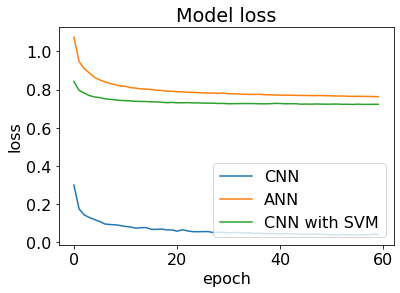

In [114]:
#plot comparison of different models
plt.matplotlib.rcParams.update({'font.size': 16})

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.plot(h.history['loss'])
plt.plot(h1.history['loss'])
plt.plot(h2.history['loss'])

plt.legend(['CNN','ANN','CNN with SVM'], loc='lower right')

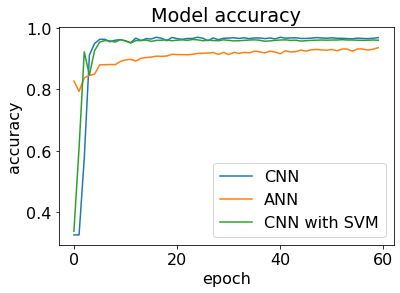

In [115]:
plt.matplotlib.rcParams.update({'font.size': 16})

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.plot(h.history['val_accuracy'])
plt.plot(h1.history['val_accuracy'])
plt.plot(h2.history['val_accuracy'])

plt.legend(['CNN','ANN','CNN with SVM'], loc='lower right')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


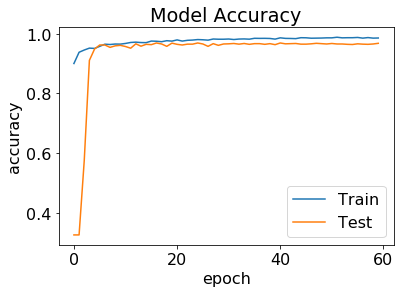

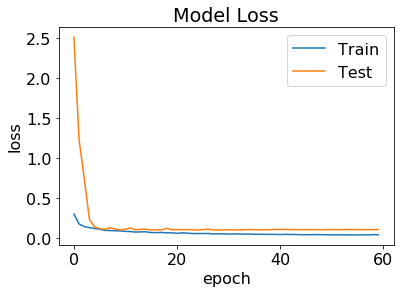

In [113]:
history=h

import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.matplotlib.rcParams.update({'font.size': 16})
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Loading and Analyzing trained model on test Set

In [45]:
from tensorflow import keras

model= keras.models.load_model('/home/cadcam/Aman/ML Based Strategy Selection/Model_dataset_a/Model_dataset_a_2/FeatureSelectorModel1')

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 50)      500       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 50)      200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 25)        11275     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 25)        100       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 25)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15625)             0

In [ ]:
# to know the activation functions used in the model
for i, layer in enumerate (model.layers):
    print (i, layer)
    try:
        print ("    ",layer.activation)
    except AttributeError:
        print('   no activation attribute')

##  Metrics using sklearn

In [64]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

x_test1=x_valid # acutal input in the form of [-1,100,100,1]
y_test=y_valid1 #actual labels not one hot encoded

# predict probabilities for test set
yhat_probs = model.predict(x_test1, verbose=0)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#auc = roc_auc_score(y_test, yhat_classes,average='macro',multi_class='ovo')
#print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

Accuracy: 0.967815
Precision: 0.968255
Recall: 0.968020
F1 score: 0.968123
Cohens kappa: 0.951714
[[573  21   0]
 [ 26 571   2]
 [  0   8 570]]
